# Preparing

## Packages

In [1]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from skimage.transform import radon
from math import radians

## Utils


In [17]:
def center_pad(array, shape, *args, **kwargs):
    pad = (np.array(shape) - np.array(array.shape)) / 2
    pad = np.array([np.floor(pad), np.ceil(pad)]).T.astype(int)
    return np.pad(array, pad, *args, **kwargs)

def circle_pad(array, *args, **kwargs):
    w, h = array.shape
    side = int(np.ceil(np.sqrt(w**2 + h**2)))
    return center_pad(array, (side, side), *args, **kwargs)

def rescale(array, min=0, max=1):
    res = array.astype('float32')
    res -= np.min(res)
    res /= np.max(res)
    res -= min
    res *= max
    return res

def get_coordinates(angle, bandwidth, no_of_detectors, center, radius):
    angles = np.linspace(0, bandwidth, no_of_detectors) + angle
    coordinates = np.array(list(zip(radius * np.cos(angles) - center[0], radius * np.sin(angles) - center[1])))
    return np.floor(coordinates).astype(int)

def bresenham_algorithm(x0, y0, x1, y1):
    if abs(y1 - y0) > abs(x1 - x0):
        swapped = True
        x0, y0, x1, y1 = y0, x0, y1, x1
    else:
        swapped = False
    m = (y1 - y0) / (x1 - x0) if x1 - x0 != 0 else +1
    q = y0 - m * x0
    if x0 < x1:
        xs = np.arange(np.floor(x0), np.ceil(x1) + 1, +1, dtype=int)
    else:
        xs = np.arange(np.ceil(x0), np.floor(x1) - 1, -1, dtype=int)
    ys = np.round(m * xs + q).astype(int)

    if swapped:
        xs, ys = ys, xs
    return xs, ys

def get_lines(detectors, emitters):
    return [np.array(bresenham_algorithm(x0, y0, x1, y1)) for (x0, y0), (x1, y1) in zip(emitters, detectors)]

def get_detectors_and_emitters(state, bandwidth, no_of_detectors, center, radius):
    return get_coordinates(radians(state-bandwidth/2), radians(bandwidth), no_of_detectors, center, radius), get_coordinates(radians(state-bandwidth/2 + 180), radians(bandwidth), no_of_detectors, center, radius)[::-1]

def one_radon_transform(state, image, no_of_detectors, center, radius, bandwidth):
    detectors, emitters = get_detectors_and_emitters(state, bandwidth, no_of_detectors, center, radius)
    lines = get_lines(detectors, emitters)
    return rescale(np.array([np.sum(image[tuple(line)]) for line in lines]))

def radon_transform(image: np.ndarray, angle_step: float, no_of_detectors: int, bandwidth: float, start: float=0, stop: float=180):
    states = np.linspace(start, stop, int((stop-start)/angle_step))
    results = np.empty((200, no_of_detectors))
    center = np.floor(np.array(image.shape) / 2).astype(int)
    radius = min(image.shape)/2
    for i, state in enumerate(states):
        results[i] = one_radon_transform(state, image, no_of_detectors, center, radius, bandwidth)
    return results


In [12]:
# theta = np.linspace(0, 180, 200)
# img = Image.open('../data/jpgs/Shepp_logan.jpg').convert('L')
# img = rescale(np.array(img), scale=0.4, mode='reflect', channel_axis=None)
# test = radon(image=np.array(img), theta=theta)
# plt.imshow(test, cmap='gray')

## Load data

In [13]:
img = Image.open('../data/jpgs/Shepp_logan.jpg').convert('L')

In [14]:
np.array(img).shape

(1024, 1024)

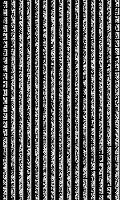

In [18]:
test = radon_transform(image=np.array(img), angle_step=1, no_of_detectors=120, bandwidth=90) # angle_step=1-4, no_of_detectors=60-120, bandwidth=90-150
test_img = Image.fromarray(test, 'L')
test_img